**INSTALACJA BIBLIOTEK**

In [1]:
!pip3 install sympy

**DEFINIOWANE OSOB, NUMERU SEKCJI, WARUNKOW POCZATKOWYCH i "INITIAL GUESS"**

In [36]:
# Definiowanie osób i numeru sekcji
osoby = [("Damian", "Gajda")] # Mozna podac dowolna liczbe osob; ostatni "nawias" w liscie nie moze byc zakonczony,
numer_sekcji = 9  # Numer sekcji

x0_vals = [0.0, 0.0, 1.0]  # przemieszczenia początkowe odpowiednio dla masy pierwszej, drugiej i trzeciej
v0_vals = [0.0, 0.0, 0.0]  # prędkości początkowe

# Nalezy zmienic tylko i wylacznie w przypadku, gdy funkcja wyznaczajaca rozwiazanie ukladu rownan zwroci blad
initial_guess = [10.0, 10.0, 10.0, 1.0, 1.0, 1.0]  # A1–A3 - wspolczynniki przy sinusach i cosinusach w rownaniach ruchu/predkosci; L1-L3 - przesuniecia fazowe w rad/s (w srodku funkcji trygonometrycznych)

In [31]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

def licz_liczbe_liter(s):
    return len(s.replace(" ", "").strip())

def wyznacz_macierze(osoby, numer_sekcji):
    imiona = [osoba[0] for osoba in osoby]
    nazwiska = [osoba[1] for osoba in osoby]

    # Masa
    m1 = licz_liczbe_liter(imiona[0]) + numer_sekcji
    m2 = 0.8 * m1
    m3 = 1.2 * m1
    M = sp.diag(m1, m2, m3)

    # Sztywność
    suma_liter_nazwisk = sum(licz_liczbe_liter(n) for n in nazwiska)
    c3 = suma_liter_nazwisk * 30 + numer_sekcji
    c1 = 2 * c3
    c2 = 0.8 * c3
    c4 = 0.5 * c3

    # Macierz sztywności
    K = sp.Matrix([
        [c1 + c2, -c2,      0],
        [-c2,     c2 + c3, -c3],
        [0,       -c3,     c3 + c4]
    ])

    print("\nMasa sprezyn m:")
    print("m1: ", m1)
    print("m2: ", m2)
    print("m3: ", m3)

    print("\nSztywnosci sprezyn c:")
    print("c1: ", c1)
    print("c2: ", c2)
    print("c3: ", c3)
    print("c4: ", c4)

    return M, K

def wyznacz_macierze_D(L_roots, M, K):
    """
    Wyznacza macierze dynamiczne D = K - L_i * M dla każdego pierwiastka L_i
    """
    macierze_D = []
    for i, Lval in enumerate(L_roots):
        D = K - Lval * M
        macierze_D.append(D)
        print(f"\n🔹 Macierz D{i+1} = K - L{i+1} * M (dla L{i+1} = {Lval.evalf():.6f}):")
        sp.pprint(D)
    return macierze_D


def wypisz_uklad_rownan(D, numer):
    """
    Dla danej macierzy D wypisuje symboliczny układ równań D * [x1, x2, x3]^T = 0
    """
    x1, x2, x3 = sp.symbols('x1 x2 x3')
    X = sp.Matrix([x1, x2, x3])
    rownania = D * X

    print(f"\n📘 Układ równań z macierzy D{numer} (D{numer} * [x1 x2 x3]^T = 0):")
    for i in range(3):
        print(f"Równanie {i+1}: ", sp.simplify(rownania[i]), "= 0")

def wektor_wlasny_numpy(D):
    """
    Oblicza przybliżony wektor własny rozwiązując D x ≈ 0 (układ jednorodny)
    """
    D_np = np.array(D.evalf()).astype(np.complex128).real
    U, S, Vh = np.linalg.svd(D_np)
    null_vec = Vh[-1]  # najmniejszy wektor

    # Normalizacja: x3 = 1
    if abs(null_vec[2]) > 1e-8:
        null_vec = null_vec / null_vec[2]

    return null_vec


def x1_x2_w_funkcji_x3_dwa_rownania(D, numer):
    """
    Wyznacza zależność x1 i x2 od x3 na podstawie równania 1 i 3 macierzy D
    """
    x1, x2, x3 = sp.symbols('x1 x2 x3')
    X = sp.Matrix([x1, x2, x3])
    rownania = D * X

    # Wybierz tylko równanie 1 i 3
    row1 = sp.Eq(sp.simplify(rownania[0]), 0)
    row3 = sp.Eq(sp.simplify(rownania[2]), 0)

    rozw = sp.solve([row1, row3], [x1, x2], dict=True)

    print(f"\n🧮 Zależność x1, x2 od x3 (tylko z równań 1 i 3 w D{numer}):")

    if rozw:
        for rozwiazanie in rozw:
            print(f"x1 = {sp.simplify(rozwiazanie[x1])}")
            print(f"x2 = {sp.simplify(rozwiazanie[x2])}")
    else:
        print("❌ Nie udało się rozwiązać układu symbolicznie.")

def analiza_numeryczna_dla_L(rzeczywiste_lambda, M, K):
    """
    Dla każdej wartości lambda (L) wyznacza numeryczny wektor własny oraz symboliczną postać drgań.
    """
    for i, lam in enumerate(rzeczywiste_lambda, 1):
        D_i = K - lam * M

        # Numeryczny wektor własny
        null_vec = wektor_wlasny_numpy(D_i)
        print(f"\n🔷 Numeryczny wektor własny dla ω{i} (λ = {lam:.4f}):")
        print(f"x ≈ {null_vec}")

        # Symboliczny nullspace
        #print(f"\n🔷 Symboliczna postać drgań dla ω{i} (λ = {lam:.4f}):")
        #nullspace = D_i.nullspace()
        #if nullspace:
        #    wektor = nullspace[0].applyfunc(lambda v: sp.N(v))
        #    print(f"x = {wektor}")
        #else:
        #    print("Brak rozwiązania (nullspace pusty).")

def wyznacz_macierz_postaci_drgan(rzeczywiste_lambda, M, K):
    """
    Buduje macierz postaci drgań (mode shape matrix), wektory własne jako kolumny.
    """
    kolumny = []
    for lam in rzeczywiste_lambda:
        D_i = K - lam * M
        null_vec = wektor_wlasny_numpy(D_i)
        kolumny.append(null_vec)

    # Transpozycja – z listy kolumn do macierzy
    Phi = np.column_stack(kolumny)

    print("\n📐 Macierz postaci drgań (mode shapes Φ):")
    print(Phi)

    return Phi


def wypisz_rownania_ruchu_z_predkosciami(phi, czestosci):
    """
    Tworzy symboliczne równania ruchu i ich pochodne (prędkości)
    x(t) = suma A_i * φ_i * sin(ω_i t + L_i)
    x'(t) = pochodna czasowa
    """
    sp.init_printing()
    t = sp.Symbol('t')
    x_expr = [0, 0, 0]
    v_expr = [0, 0, 0]

    A = sp.symbols('A1 A2 A3')
    L = sp.symbols('L1 L2 L3')

    for i in range(3):  # tryby
        omega_i = czestosci[i]
        for j in range(3):  # współrzędne x1, x2, x3
            term = A[i] * phi[j, i] * sp.sin(omega_i * t + L[i])
            dterm = sp.diff(term, t)
            x_expr[j] += term
            v_expr[j] += dterm

    print("\n🧮 Symboliczne równania ruchu:")
    for j in range(3):
        print(f"x{j+1}(t) = ", end="")
        sp.pprint(sp.simplify(x_expr[j]))

    print("\n🧮 Symboliczne równania prędkości:")
    for j in range(3):
        print(f"x{j+1}'(t) = ", end="")
        sp.pprint(sp.simplify(v_expr[j]))

def rozwiaz_z_warunkami_poczatkowymi(phi, czestosci, x0_vals, v0_vals,initial_guess=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]):
    """
    Rozwiązuje układ 6 równań dla A_i i L_i (Lambda_i) z warunków początkowych.
    :param phi: macierz postaci drgań (3x3, np. numpy)
    :param czestosci: lista ω_i
    :param x0_vals: lista przesunięć początkowych [x1(0), x2(0), x3(0)]
    :param v0_vals: lista prędkości początkowych [x1'(0), x2'(0), x3'(0)]
    """

    A = sp.symbols('A1 A2 A3')
    L = sp.symbols('L1 L2 L3')
    eqs = []

    # Równania przemieszczeń początkowych (t=0)
    for j in range(3):
        expr = sum(A[i] * phi[j, i] * sp.sin(L[i]) for i in range(3))
        eqs.append(sp.Eq(expr, x0_vals[j]))

    # Równania prędkości początkowych (t=0)
    for j in range(3):
        expr = sum(A[i] * phi[j, i] * czestosci[i] * sp.cos(L[i]) for i in range(3))
        eqs.append(sp.Eq(expr, v0_vals[j]))

    print("\n📐 Układ równań do rozwiązania (symboleczne):")
    for eq in eqs:
        sp.pprint(eq)

    # Symbole do rozwiązania
    zmienne = list(A) + list(L)

    # Rozwiązanie (numeryczne)
    #initial_guess = [10.0, 10.0, 10.0, 1, 1, 1]  # A1–A3 = 1.0, L1–L3 = 0.1 rad
    rozw = sp.nsolve(eqs, zmienne, initial_guess)

    print("\n✅ Rozwiązanie:")
    for var, val in zip(zmienne, rozw):
        print(f"{var} = {val.evalf():.4f}")

    return dict(zip(zmienne, rozw))


def generuj_wykresy_i_wzory(phi, czestosci, rozwiazanie):
    """
    Generuje wykresy x1(t), x2(t), x3(t) oraz wspólny wykres, a także wypisuje równania ruchu
    z uwzględnieniem rozwiązanych amplitud i faz początkowych.
    """
    t = sp.Symbol('t')
    x_expr = [0, 0, 0]

    # Wyodrębnij wartości A_i i L_i z rozwiązania
    A = [rozwiazanie[sp.Symbol(f'A{i+1}')] for i in range(3)]
    L = [rozwiazanie[sp.Symbol(f'L{i+1}')] for i in range(3)]

    # Budujemy symboliczne równania ruchu
    for j in range(3):
        for i in range(3):
            x_expr[j] += A[i] * phi[j, i] * sp.sin(czestosci[i] * t + L[i])

    x_expr = [sp.simplify(expr) for expr in x_expr]

    # Wypisanie równań
    print("\n📘 Równania ruchu z podstawionymi wartościami A_i i L_i:")
    for i, expr in enumerate(x_expr, 1):
        print(f"x{i}(t) = ")
        sp.pprint(expr)

    # Funkcje numeryczne
    x_funcs = [sp.lambdify(t, expr, modules='numpy') for expr in x_expr]

    # Zakres czasu: 0–20s, co 0.01s
    t_vals = np.arange(0, 20.01, 0.01)
    x_vals = [f(t_vals) for f in x_funcs]

    # Rysowanie wykresów
    width_inch = 20 * 1.8 / 2.54  # Skala: 1.8 cm = 1s
    fig, axs = plt.subplots(4, 1, figsize=(width_inch, 12), sharex=True)
    colors = ['tab:blue', 'tab:orange', 'tab:green']
    labels = ['x1(t)', 'x2(t)', 'x3(t)']

    for i in range(3):
        axs[i].plot(t_vals, x_vals[i], label=labels[i], color=colors[i])
        axs[i].set_ylabel(labels[i])
        axs[i].set_xlabel('t [s]')
        axs[i].legend()
        axs[i].grid(True)
        axs[i].set_xlim([0, 20])
        axs[i].set_xticks(np.arange(0, 21, 1))


    # Wspólny wykres
    for i in range(3):
        axs[3].plot(t_vals, x_vals[i], label=labels[i],
                    linestyle='-' if i == 0 else '--' if i == 1 else '-.', color=colors[i])
    axs[3].set_ylabel('x1, x2, x3')
    axs[3].set_xlabel('t [s]')
    axs[3].legend()
    axs[3].grid(True)
    axs[3].set_xlim([0, 20])
    axs[3].set_xticks(np.arange(0, 21, 1))

    plt.tight_layout()
    plt.show()




In [37]:
def main(osoby, numer_sekcji, x0_vals, v0_vals, initial_guess):
    print("=== Symboliczne obliczenia: D = K - L*M ===")

    # Wyświetlanie komunikatów "jakby input"
    for osoba in osoby:
        print(f"Imię i nazwisko osoby z sekcji (kolejnosc istotna!!!): {osoba}")
    #print("Podaj imię i nazwisko osoby (lub ENTER aby zakończyć): ")
    print(f"Numer sekcji: {numer_sekcji}")

    M, K = wyznacz_macierze(osoby, numer_sekcji)

    L = sp.Symbol('L')
    D = K - L * M

    print("\nMacierz mas M:")
    sp.pprint(M)

    print("\nMacierz sztywności K:")
    sp.pprint(K)

    print("\nMacierz dynamiczna D = K - L*M:")
    sp.pprint(D)

    det_D = D.det()
    det_D_expanded = sp.expand(det_D)

    print("\nWyznacznik det(D):")
    sp.pprint(det_D)

    print("\nRozwinięty wielomian det(D) w L:")
    sp.pprint(det_D_expanded)

    rozwiazania = sp.solve(det_D_expanded, L)

    rzeczywiste_L = []
    print("\nPierwiastki wielomianu (L = omega^2):")
    for i, r in enumerate(rozwiazania, 1):
        real_L = r.as_real_imag()[0].evalf()
        rzeczywiste_L.append(real_L)
        print(f"L{i} = {real_L:.6f}")

    print("\nCzęstości własne omega [rad/s]:")
    for i, Lval in enumerate(rzeczywiste_L, 1):
        omega = sp.sqrt(Lval).evalf()
        print(f"omega{i} = {omega:.6f}")

    D_macierze = wyznacz_macierze_D(rzeczywiste_L, M, K)

    for i, D in enumerate(D_macierze, 1):
        wypisz_uklad_rownan(D, i)
        x1_x2_w_funkcji_x3_dwa_rownania(D, i)

    analiza_numeryczna_dla_L(rzeczywiste_L, M, K)
    Phi = wyznacz_macierz_postaci_drgan(rzeczywiste_L, M, K)
    czestosci = [sp.sqrt(Lval).evalf() for Lval in rzeczywiste_L]
    wypisz_rownania_ruchu_z_predkosciami(Phi, czestosci)

    rozw = rozwiaz_z_warunkami_poczatkowymi(Phi, czestosci, x0_vals, v0_vals, initial_guess)
    generuj_wykresy_i_wzory(Phi, czestosci, rozw)


=== Symboliczne obliczenia: D = K - L*M ===
Imię i nazwisko osoby z sekcji (kolejnosc istotna!!!): ('Damian', 'Gajda')
Numer sekcji: 9

Sztywnosci sprezyn c:
c1:  318
c2:  127.2
c3:  159
c4:  79.5

Macierz mas M:
⎡15   0     0  ⎤
⎢              ⎥
⎢0   12.0   0  ⎥
⎢              ⎥
⎣0    0    18.0⎦

Macierz sztywności K:
⎡445.2   -127.2    0  ⎤
⎢                     ⎥
⎢-127.2  286.2   -159 ⎥
⎢                     ⎥
⎣  0      -159   238.5⎦

Macierz dynamiczna D = K - L*M:
⎡445.2 - 15⋅L      -127.2            0       ⎤
⎢                                            ⎥
⎢   -127.2     286.2 - 12.0⋅L       -159     ⎥
⎢                                            ⎥
⎣     0             -159       238.5 - 18.0⋅L⎦

Wyznacznik det(D):
          3             2                           
- 3240.0⋅L  + 216367.2⋅L  - 3921083.1⋅L + 15274780.2

Rozwinięty wielomian det(D) w L:
          3             2                           
- 3240.0⋅L  + 216367.2⋅L  - 3921083.1⋅L + 15274780.2

Pierwiastki wielomianu (

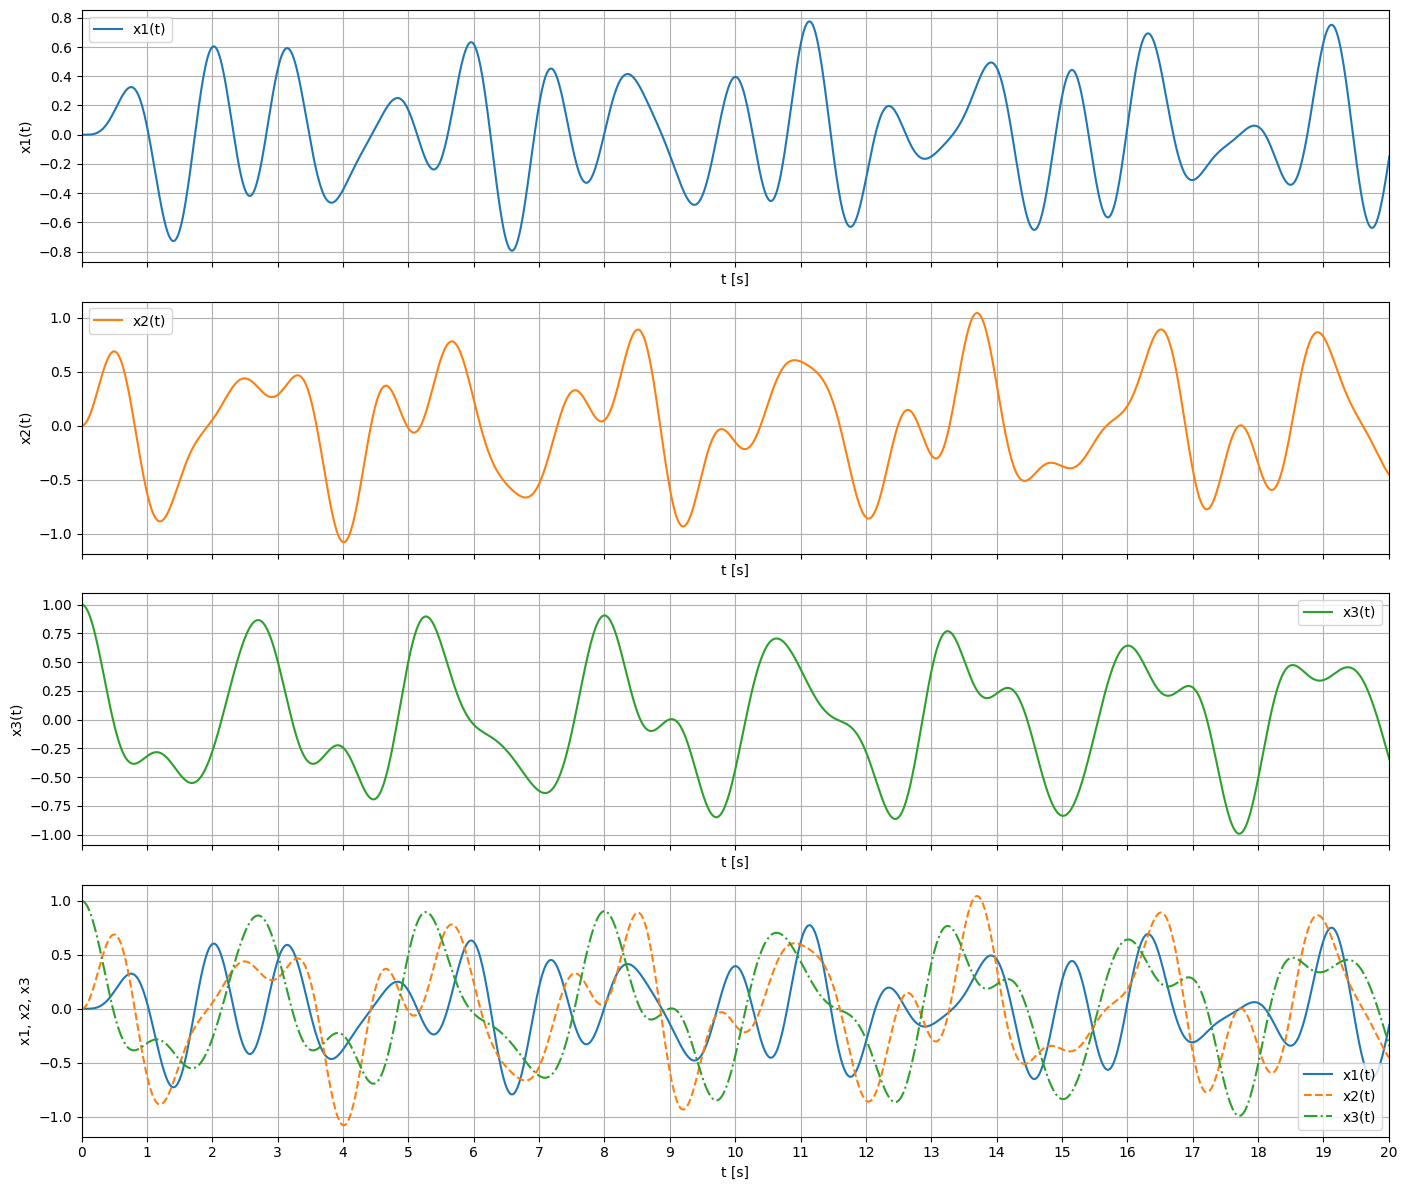

In [38]:
main(osoby, numer_sekcji, x0_vals, v0_vals, initial_guess)